# Cameroon Vitamin A Effective Coverage MINIMOD Simulations

-  This uses Vitamin A Eff. Coverage and 6-59 mos. children population data

In [1]:
import pandas as pd
import geopandas as gpd
import minimod
import matplotlib.pyplot as plt
from ipywidgets import fixed, interact, IntSlider

data_folder = 'Optimization Work/demewoz_lives_saved/data_files/'

effective_coverage_folder = data_folder + 'effective_coverage/'
cost_folder = data_folder + 'new_cost_benefits/'


In [2]:
# Get intervention names to change
va_eff_cov = (
pd.read_excel(effective_coverage_folder + 'April28_Vitamin A_Effective_ coverage.xlsx')
)

long_intervention_names = va_eff_cov['Vitamin A intervention'].unique().tolist()
short_intervention_names = ['cube',
'oilclinic',
'maxoil',
'maxoilcube',
'oil',
'maxoilcubeclinic',
'oilcube',
'oilcubeclinic',
'maxoilclinic',
'clinic',
'cubeclinic',
'vas',
'maxoilvas',
'maxoilvas',
'oilvas',
'oilvas',
'cubevas',
'oilcubevas',
'oilcubevas',
'maxoilcubevas'
]
intervention_rename_list = {k:v for k,v in zip(long_intervention_names, short_intervention_names)}

## Data Processing

In [3]:
# First load in cost data
costs = pd.read_excel(cost_folder + 'lives_saved_costs.xlsx', sheet_name='costs')

# Then VA Effective Coverage
va_eff_cov = (
pd.read_excel(effective_coverage_folder + 'April28_Vitamin A_Effective_ coverage.xlsx')
.assign(intervention = lambda df: df['Vitamin A intervention'].replace(intervention_rename_list),
region = lambda df: df['Zone'].str.strip())
)

# 6-59 Mos. Children
pop = (
pd.read_excel(effective_coverage_folder + 'Cameroon Population age6-59 months.xlsx', skiprows=1)
.replace({'Region' : {'Urban' : 'Cities'}})
.loc[:, ['Region'] + [f"Sum of {year}" for year in range(2020, 2030,1)]]
.rename({'Region' : 'region'}, axis=1)
)
## Using 2020 - 2029 -> 1-10


In [4]:
def year_func(year, col = 'effective_coverage'):
    return lambda df: (df[col]/100)*df[f'Sum of {year}']

df_benefits_mean = (
va_eff_cov
.merge(pop, on = 'region')
.assign(
**{str(num + 1) : year_func(year) for num, year in enumerate(range(2020, 2030,1))})
[['intervention', 'region'] + [str(x) for x in range(1,11,1)]]
.set_index(['intervention', 'region'])
.stack()
.reset_index()
.rename({'level_2' : 'time',
0 : 'eff_cov_mean'}, axis=1)
.assign(time = lambda df: df['time'].astype(int))
)

df_benefits_sd = (
va_eff_cov
.merge(pop, on = 'region')
.assign(
**{str(num + 1) : year_func(year, 'effective_coverage_SE') for num, year in enumerate(range(2020, 2030,1))})
[['intervention', 'region'] + [str(x) for x in range(1,11,1)]]
.set_index(['intervention', 'region'])
.stack()
.reset_index()
.rename({'level_2' : 'time', 0 : 'eff_cov_sd'}, axis=1)
.assign(time = lambda df: df['time'].astype(int))
)

df_benefits = df_benefits_mean.merge(df_benefits_sd, on  = ['intervention', 'region', 'time'])

In [5]:
# Create costs
df_costs = (
costs
.set_index(['intervention', 'region'])
.stack()
.reset_index()
.rename({'level_2' : 'time', 0 : 'costs'}, axis=1)
)


In [6]:
df = df_benefits.merge(df_costs, on = ['intervention', 'region', 'time'])


In [7]:
# Create function to make data adjustments
def observation_adjustment(data, int1, int2, time_to_replace, space_to_replace = slice(None)):
    
    df = data.copy(deep = True)

    if isinstance(int2, str):
        df_int2 = df.loc[(int2, space_to_replace, time_to_replace)]
        df.loc[(int1, space_to_replace, time_to_replace), :] = df_int2.values
    elif int2 == 0:
        df.loc[(int1, space_to_replace, time_to_replace), :] = 0

    print(f"Changed {int1} to {int2}")

    return df

In [8]:
df_adjusted = (df.set_index(['intervention', 'region', 'time'])
.pipe(observation_adjustment,
int1 = "cube",
int2 = 0,
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcube",
int2 = "maxoil",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcube",
int2 = "oil",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubevas",
int2 = "oilvas",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubevas",
int2 = "maxoilvas",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubevas",
int2 = "vas",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "cubeclinic",
int2 = "clinic",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoilcubeclinic",
int2 = "maxoilclinic",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "oilcubeclinic",
int2 = "oilclinic",
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "maxoil",
int2 = "oil",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcube",
int2 = "oilcube",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilvas",
int2 = "oilvas",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcubevas",
int2 = "oilcubevas",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilclinic",
int2 = "oilclinic",
time_to_replace = [1,2])
.pipe(observation_adjustment,
int1 = "maxoilcubeclinic",
int2 = "oilcubeclinic",
time_to_replace = [1,2])
)


Changed cube to 0
Changed maxoilcube to maxoil
Changed oilcube to oil
Changed oilcubevas to oilvas
Changed maxoilcubevas to maxoilvas
Changed cubevas to vas
Changed cubeclinic to clinic
Changed maxoilcubeclinic to maxoilclinic
Changed oilcubeclinic to oilclinic
Changed maxoil to oil
Changed maxoilcube to oilcube
Changed maxoilvas to oilvas
Changed maxoilcubevas to oilcubevas
Changed maxoilclinic to oilclinic
Changed maxoilcubeclinic to oilcubeclinic


## Summary Tables

In [9]:
df_adjusted.index.get_level_values(level=0).unique()

Index(['cube', 'oilclinic', 'maxoil', 'maxoilcube', 'oil', 'maxoilcubeclinic',
       'oilcube', 'oilcubeclinic', 'maxoilclinic', 'clinic', 'cubeclinic',
       'vas', 'maxoilvas', 'oilvas', 'cubevas', 'oilcubevas', 'maxoilcubevas'],
      dtype='object', name='intervention')

In [10]:

s = minimod.utils.summary.PreOptimizationDataSummary(
    data = df_adjusted.reset_index(),
    benefit_col= 'eff_cov_mean',
    cost_col= 'costs',
    intervention_col='intervention',
    space_col= 'region',
    time_col='time',
    benefit_title='Children Effectively Covered',
    intervention_subset=['clinic', 'vas', 'cube', 'oil', 'maxoil', 'vasoil'],
    intervention_subset_titles={'clinic' : 'VAS Clinic Day', 
    'vas' : 'Vitamin A Supp.', 
    'cube' : 'Boullion Cube',
    'oil' : 'Oil (75%)',
    'maxoil' : 'Oil (100%)',
    'oilvas' : 'BAU: Vitamin A Supp. + Oil (75%)'},
    bau_intervention = 'oilvas'
)

s.summary_table(variables_of_interest= {'Cost per Child ($)' : 'cost_per_benefit'}, grouping = 'over_space', style = 'markdown')


,Intervention,Regions,Children Effectively Covered,Costs ($),Cost per Child ($)
2,VAS Clinic Day,North,"5,832,607","2,865,447",0.490000
3,VAS Clinic Day,South,"3,516,588","3,841,020",1.090000
0,VAS Clinic Day,Cities,"2,357,751","1,122,793",0.480000
1,VAS Clinic Day,National,"11,706,947","7,829,259",0.670000
22,Vitamin A Supp.,North,"982,175","10,255,678",10.440000
23,Vitamin A Supp.,South,"508,783","13,732,668",26.990000
20,Vitamin A Supp.,Cities,"337,787","5,679,748",16.810000
21,Vitamin A Supp.,National,"1,828,744","29,668,094",16.220000
6,Boullion Cube,North,"2,361,042","3,358,510",1.420000
7,Boullion Cube,South,"1,729,070","3,694,965",2.140000


## Simulations



In [11]:
m = minimod.Minimod(solver_type = 'costmin',
data = df_adjusted,
benefit_col = 'eff_cov_mean',
cost_col = 'costs',
space_col = 'region',
all_space = ['cube', '(?=.*(?<![max])oil)', 'maxoil'],
all_time = ['cube', '(?=.*(?<![max])oil)', 'maxoil'],
time_subset = [1,2,3],
benefit_title = 'Children Effectively Covered (VA)',
minimum_benefit = 'oilvas',
)

[Note]: Processing Data...
[Note]: Creating Base Model with constraints

                MiniMod Nutrition Intervention Tool
                Optimization Method: MIN
                Version: 0.0.5dev
                Solver: CBC,
                Show Output: True
                
                


In [12]:
m.fit()

[Note]: Optimizing...
[Note]: Optimal Solution Found


In [13]:
m.report()

+----------------------------+----------------------------+
| MiniMod Solver Results     |                            |
| Method:                    | MIN                        |
| Solver:                    | CBC                        |
| Optimization Status:       | OptimizationStatus.OPTIMAL |
| Number of Solutions Found: | 1                          |
+----------------------------+----------------------------+
+-----------------------------+------+
| No. of Variables:           |  510 |
| No. of Integer Variables:   |  510 |
| No. of Constraints          |  454 |
| No. of Non-zeros in Constr. | 6933 |
+-----------------------------+------+
Interventions Chosen:
+-----------------------------------------+-------------+
| Minimum Benefit                         | 6.10421e+06 |
| Objective Bounds                        | 3.39098e+06 |
| Total Cost                              | 3.39098e+06 |
| Total Children Effectively Covered (VA) | 6.20111e+06 |
+---------------------------------

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f67eb1b1b20>)

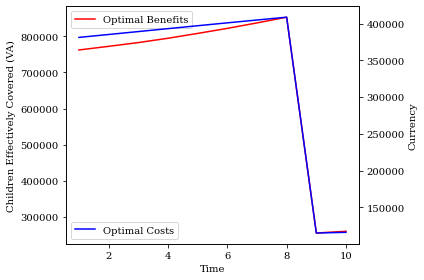

In [14]:
m.plot_time()


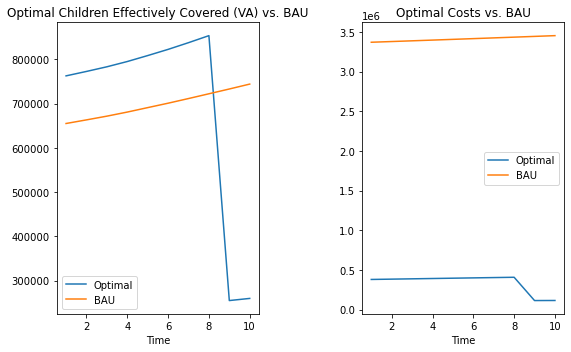

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2,  figsize = (8,5))
m.plot_bau_time(ax=ax1)
m.plot_bau_time(opt_variable = 'c', ax=ax2)
plt.savefig("low_bau.png", dpi=600)

In [16]:
# Load data
geo_df = gpd.read_file("examples/data/maps/cameroon/CAM.shp")

# Now we create the boundaries for North, South and Cities
# Based on "Measuring Costs of Vitamin A..., Table 2"
north = r"Adamaoua|Nord|Extreme-Nord"
south = r"Centre|Est|Nord-Ouest|Ouest|Sud|Sud-Ouest"
cities= r"Littoral" # Duala
# Yaounde is in Mfoundi
geo_df.loc[lambda df: df['ADM1'].str.contains(north), 'space'] = 'North'
geo_df.loc[lambda df: df['ADM1'].str.contains(south), 'space'] = 'South'
geo_df.loc[lambda df: df['ADM1'].str.contains(cities), 'space'] = 'Cities'
geo_df.loc[lambda df: df['ADM2'].str.contains(r"Mfoundi"), 'space'] = 'Cities'

# Now we aggregate the data to the `space` variable
agg_geo_df = geo_df.dissolve(by = 'space')


In [17]:
interact(m.plot_map_benchmark, 
intervention = fixed('clinic'), 
time = IntSlider(min=1, max=10, step=1, value=1), 
optimum_interest = ['b', 'c', 'cdb', 'cdc', 'cb', 'cc'], 
bench_intervention = fixed('oilvas'),
map_df = fixed(agg_geo_df),
merge_key = fixed('space'),
save = fixed(None))

interactive(children=(IntSlider(value=1, description='time', max=10, min=1), Dropdown(description='optimum_int…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>